**Devènes Florian & Robyr Eloi**

# Projet : analyse séquentielle de data 

## Analyse de la série temporelle des utilisateurs connectés à l'environnement steam

In [86]:
# Import libraries
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm


In [87]:
# Cut data when until 3 consecutive lines don't have NaN in 'Users' and 'Average Users'

def cut_data(df):
    count = 0
    cut_index = len(df)  # Default to full length if no cut is found

    for i in range(len(df)-1, -1, -1):
        if pd.notna(df.loc[i, 'Users']) and pd.notna(df.loc[i, 'Average Users']):
            count += 1
            if count == 3:
                cut_index = i
                break
        else:
            count = 0

    return df.iloc[cut_index:]

**Data pull**

In [170]:
data_dir = 'Data'
data_dict = {}

for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        # Exemple de nom de fichier : steamdb_chart_cs2_players.csv
        match = re.search(r"steamdb_chart_(.*?)_", file)
        if match:
            name = match.group(1)  # extrait "cs2"
            df = pd.read_csv(os.path.join(data_dir, file),sep=';')
            df["Source"] = name
            df = cut_data(df)
            data_dict[name] = df
        else:
            print(f"⚠️ Nom de fichier ignoré : {file}")

l48hdata = data_dict.get('last48h')
x = l48hdata['DateTime']
y = l48hdata['Users']


In [171]:
l48hdata

,DateTime,Users,Average Users,In-Game,Source
8503,2025-11-03 09:00:00,27915078.0,31546118.0,6668369.0,last48h
8504,2025-11-03 10:00:00,29897799.0,31394129.0,7311315.0,last48h
8505,2025-11-03 11:00:00,30281315.0,31248491.0,8405322.0,last48h
8506,2025-11-03 11:10:00,30742067.0,NaN,8405322.0,last48h
8507,2025-11-03 11:20:00,31171445.0,NaN,8405322.0,last48h
...,...,...,...,...,...
9511,2025-11-10 10:40:00,28851596.0,NaN,6961587.0,last48h
9512,2025-11-10 10:50:00,29229726.0,NaN,6961587.0,last48h
9513,2025-11-10 11:00:00,29619305.0,31288293.0,7372704.0,last48h
9514,2025-11-10 11:10:00,30088990.0,NaN,7372704.0,last48h


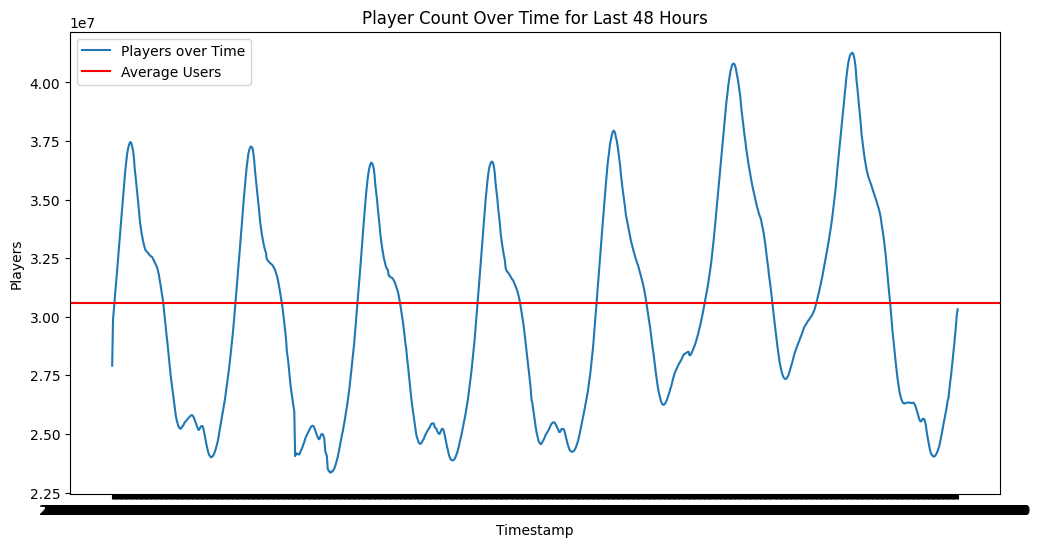

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(l48hdata['DateTime'], l48hdata['Users'], label='Players over Time')
plt.axhline(y=l48hdata['Average Users'].mean(), color='r', linestyle='-', label='Average Users')
plt.xlabel('Timestamp') 
plt.ylabel('Players')
plt.title('Player Count Over Time for Last week')
plt.legend()
plt.show()

# SARIMAX modelisation

**Auto-regressive**

c:\Users\xenio\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0, 0.5, 'Players')

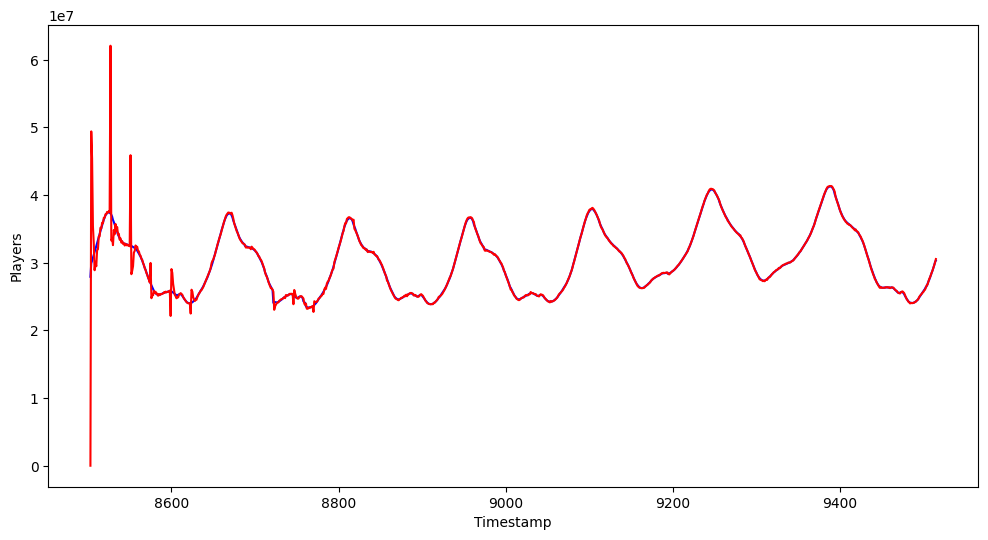

In [159]:
#Auto-regressive
p=2
d=2
q=3


model = sm.tsa.SARIMAX(y, order=(p, d, q), seasonal_order=(2,2 ,3, 24), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()

plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual Players', color='blue')
plt.plot(model_fit.fittedvalues, color='red', label='Fitted Values')
plt.xlabel('Timestamp') 
plt.ylabel('Players')

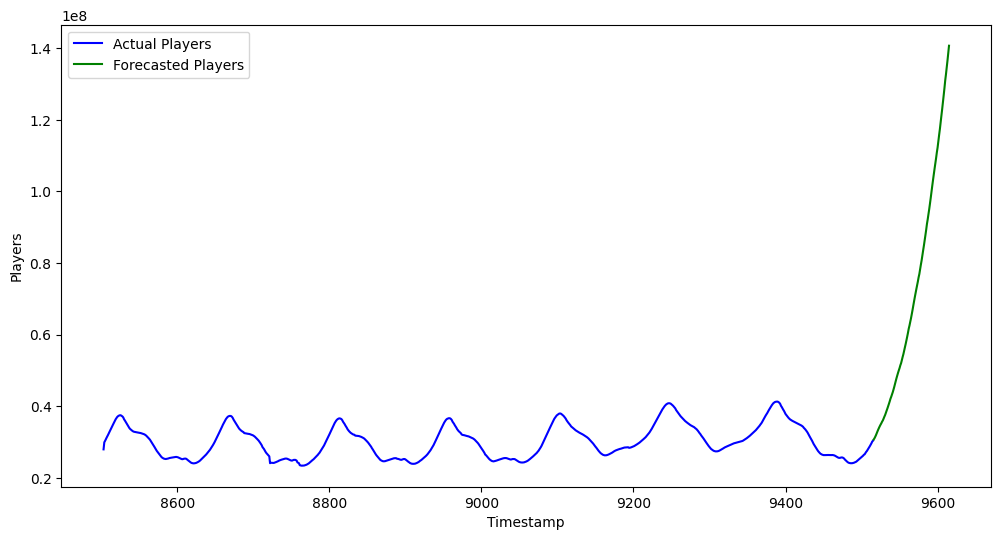

In [165]:
forecast = model_fit.forecast(steps=100)

plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual Players', color='blue')
plt.plot(forecast, color='green', label='Forecasted Players')
plt.xlabel('Timestamp')
plt.ylabel('Players')
plt.legend()
plt.show()


Text(0.5, 0, 'Timestamp')

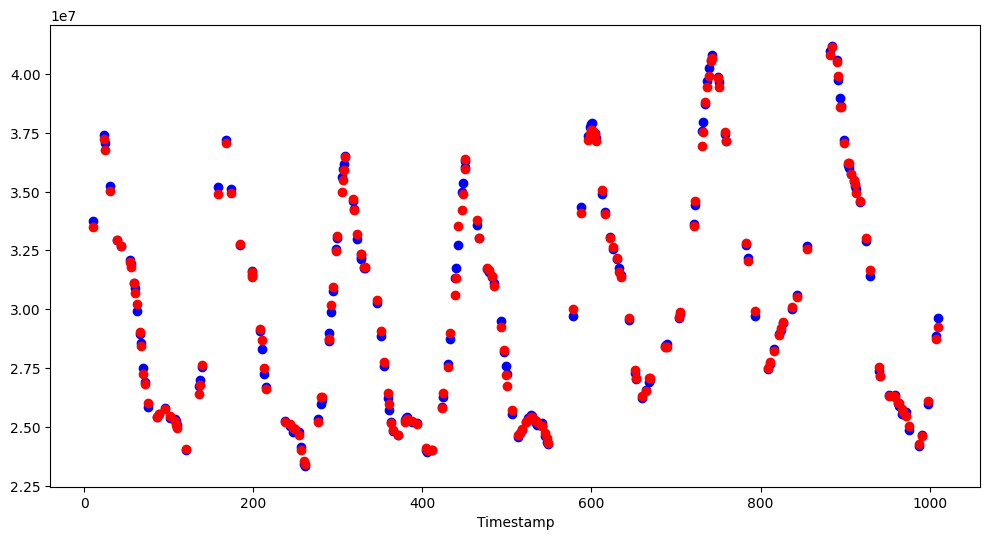

In [164]:
# K-nn model to classify points in a time series to what sub-series they belong
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
X = np.array(range(len(y))).reshape(-1, 1)  # Reshape for sklearn
y_values = y.values
X_train, X_test, y_train, y_test = train_test_split(X, y_values, test_size=0.2, random_state=42)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Players')
plt.scatter(X_test, y_pred, color='red', label='Predicted Players')
plt.xlabel('Timestamp')

